In [ ]:
# ============================================================
# 0. GEREKLİ KÜTÜPHANELER
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ============================================================
# 1. GOOGLE DRIVE BAĞLANTISI
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/tic+tac+toe+endgame/tic-tac-toe.data"  # Kendine göre düzenle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================================
# 2. VERİYİ YÜKLE
# ============================================================

col_names = [
    "top-left-square", "top-middle-square", "top-right-square",
    "middle-left-square", "middle-middle-square", "middle-right-square",
    "bottom-left-square", "bottom-middle-square", "bottom-right-square",
    "class"
]

df = pd.read_csv(path, header=None, names=col_names)
print(df.head())

  top-left-square top-middle-square top-right-square middle-left-square  \
0               x                 x                x                  x   
1               x                 x                x                  x   
2               x                 x                x                  x   
3               x                 x                x                  x   
4               x                 x                x                  x   

  middle-middle-square middle-right-square bottom-left-square  \
0                    o                   o                  x   
1                    o                   o                  o   
2                    o                   o                  o   
3                    o                   o                  o   
4                    o                   o                  b   

  bottom-middle-square bottom-right-square     class  
0                    o                   o  positive  
1                    x                   o  posi

In [ ]:
# ============================================================
# 3. ÖN İŞLEME
# ============================================================

X = df.drop("class", axis=1)
y = df["class"]

le = LabelEncoder()
X_encoded = X.apply(le.fit_transform)
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
# ============================================================
# 4. TEMEL MODELLER
# ============================================================

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=400)
}

results = {}

In [ ]:
# ============================================================
# 5. MODEL EĞİTİMİ VE PERFORMANCE
# ============================================================

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print("================================")
    print(f"MODEL: {name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

MODEL: Logistic Regression
Accuracy: 0.671875
              precision    recall  f1-score   support

           0       0.57      0.25      0.35        67
           1       0.69      0.90      0.78       125

    accuracy                           0.67       192
   macro avg       0.63      0.57      0.57       192
weighted avg       0.65      0.67      0.63       192

MODEL: KNN
Accuracy: 0.859375
              precision    recall  f1-score   support

           0       0.95      0.63      0.76        67
           1       0.83      0.98      0.90       125

    accuracy                           0.86       192
   macro avg       0.89      0.81      0.83       192
weighted avg       0.87      0.86      0.85       192

MODEL: SVM (RBF)
Accuracy: 0.8645833333333334
              precision    recall  f1-score   support

           0       0.98      0.63      0.76        67
           1       0.83      0.99      0.91       125

    accuracy                           0.86       192
   mac

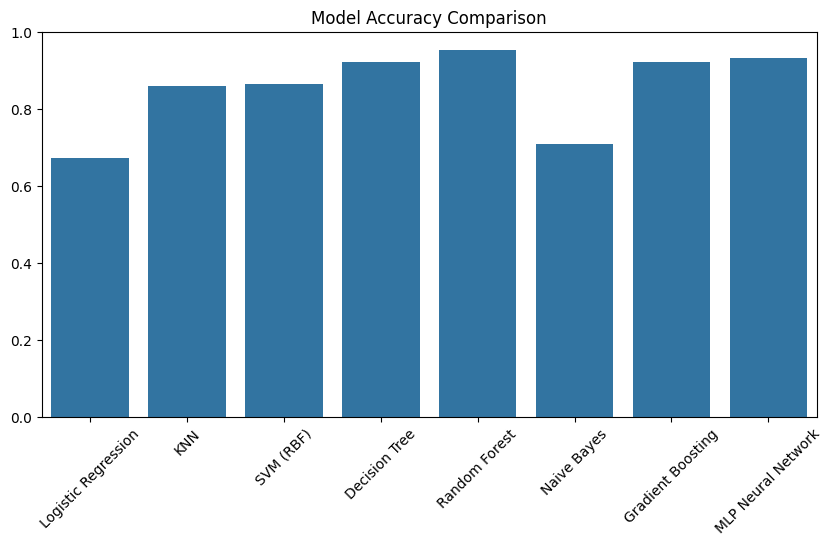

In [ ]:
# ============================================================
# 6. BAR PLOT: MODEL KARŞILAŞTIRMA
# ============================================================

plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.show()

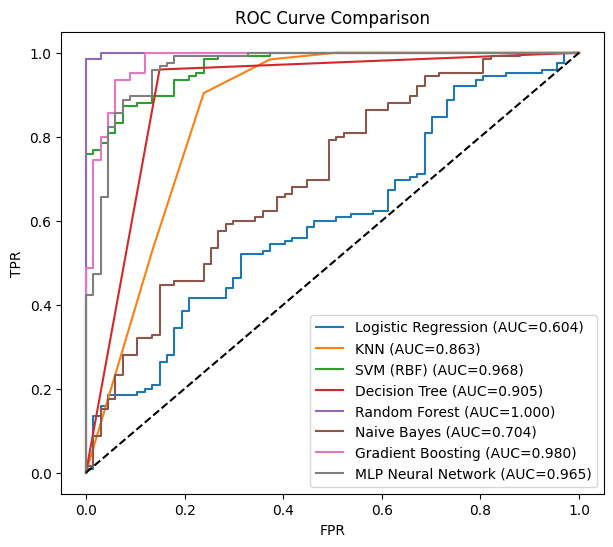

In [ ]:
# ============================================================
# 7. ROC - AUC
# ============================================================

plt.figure(figsize=(7,6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve Comparison")
plt.show()

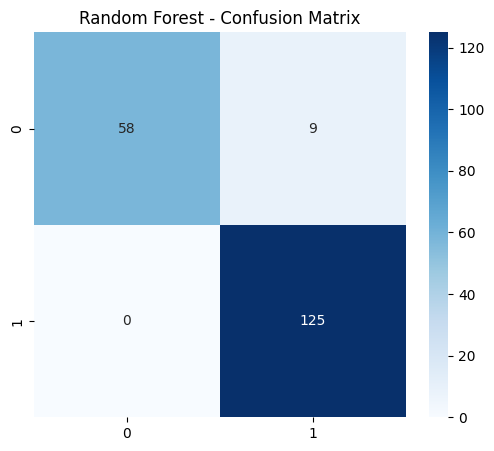

In [ ]:
# ============================================================
# 8. CONFUSION MATRIX (BEST MODEL)
# ============================================================

best_name = max(results, key=results.get)
best_model = models[best_name]

cm = confusion_matrix(y_test, best_model.predict(X_test))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title(f"{best_name} - Confusion Matrix")
plt.show()

In [ ]:
# ============================================================
# 9. XGBOOST MODELİ
# ============================================================

!pip install xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00       125

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



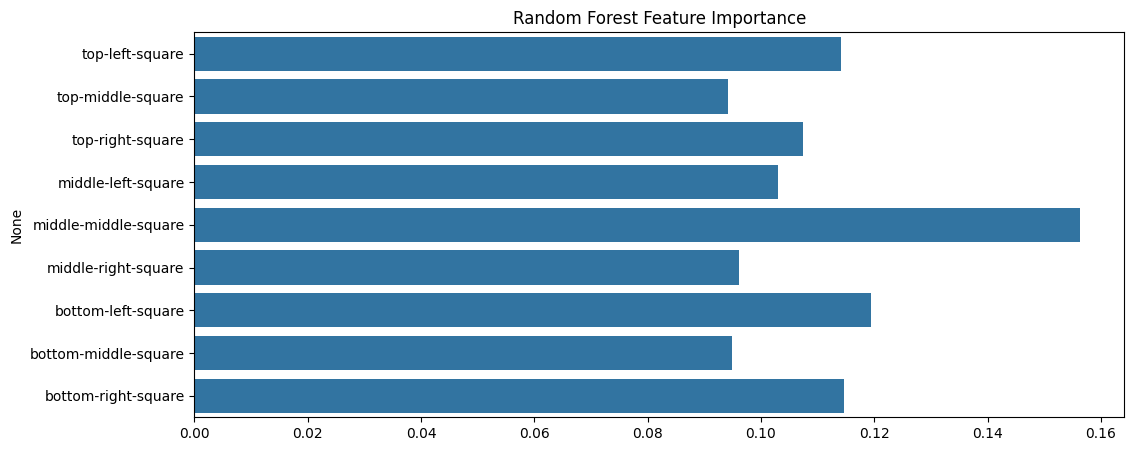

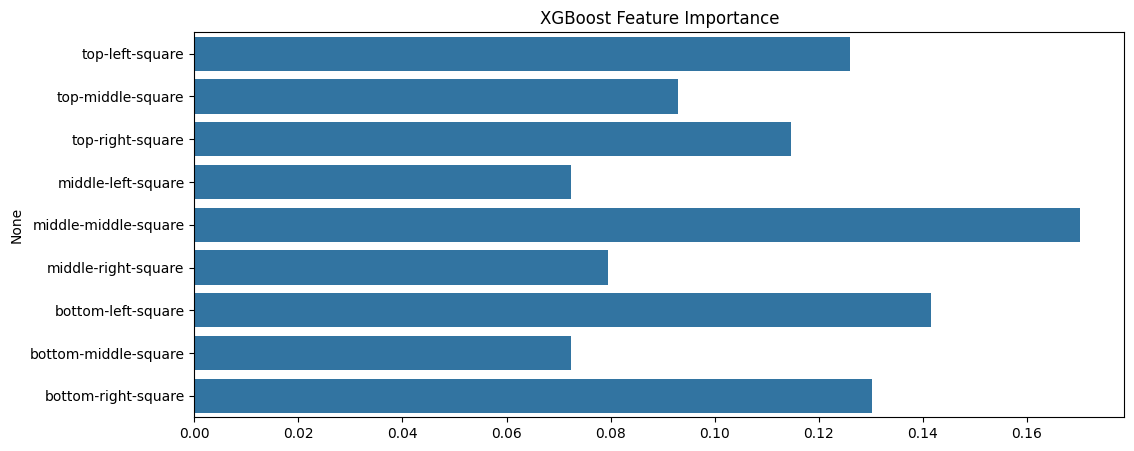

In [ ]:
# ============================================================
# 10. FEATURE IMPORTANCE (RF + XGB)
# ============================================================

plt.figure(figsize=(12,5))
sns.barplot(x=RandomForestClassifier().fit(X_train, y_train).feature_importances_,
            y=X_train.columns)
plt.title("Random Forest Feature Importance")
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(x=xgb.feature_importances_, y=X_train.columns)
plt.title("XGBoost Feature Importance")
plt.show()


In [ ]:
# ============================================================
# 11. GRIDSEARCHCV – HİPERPARAMETRE OPTİMİZASYONU
# ============================================================

param_knn = {'n_neighbors': [3,5,7,9]}
gs_knn = GridSearchCV(KNeighborsClassifier(), param_knn, cv=5)
gs_knn.fit(X_train, y_train)
print("Best KNN:", gs_knn.best_params_)

param_svm = {'C':[0.1,1,10], 'gamma':['scale','auto']}
gs_svm = GridSearchCV(SVC(probability=True), param_svm, cv=5)
gs_svm.fit(X_train, y_train)
print("Best SVM:", gs_svm.best_params_)

param_rf = {'n_estimators':[100,200,300], 'max_depth':[3,5,7]}
gs_rf = GridSearchCV(RandomForestClassifier(), param_rf, cv=5)
gs_rf.fit(X_train, y_train)
print("Best RF:", gs_rf.best_params_)

Best KNN: {'n_neighbors': 5}
Best SVM: {'C': 10, 'gamma': 'scale'}
Best RF: {'max_depth': 7, 'n_estimators': 100}


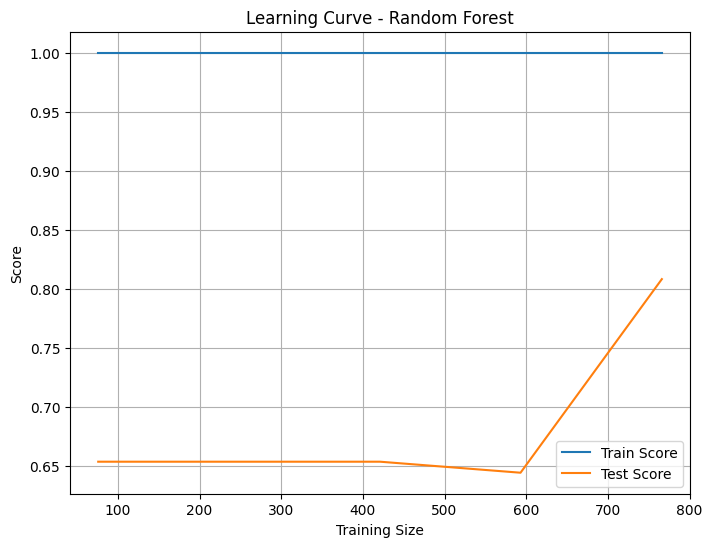

In [ ]:
# ============================================================
# 12. LEARNING CURVE (BEST MODEL)
# ============================================================

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_encoded, y_encoded, cv=5,
    train_sizes=np.linspace(0.1,1.0,5)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Train Score")
plt.plot(train_sizes, test_mean, label="Test Score")
plt.xlabel("Training Size")
plt.ylabel("Score")
plt.title(f"Learning Curve - {best_name}")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ============================================================
# 13. TEK SATIR TAHMİN ÖRNEĞİ (GERÇEK vs MODEL TAHMİNİ)
# ============================================================

import random

# Test setinden rastgele bir index seç
index = random.randint(0, len(X_test) - 1)

# Seçilen satır
sample = X_test.iloc[index]
sample_reshaped = sample.values.reshape(1, -1)

# Gerçek sınıf
real_class = y_test[index]

# Tahmin edilen sınıf
pred_class = best_model.predict(sample_reshaped)[0]
pred_prob = best_model.predict_proba(sample_reshaped)[0]

# LabelEncoder ile sınıf isimlerini geri dönüştür
class_names = le.inverse_transform([0,1])

print("=====================================")
print("🔍 Rastgele Seçilen Satır Özellikleri:\n")
print(sample)
print("\n=====================================")
print(f"🎯 Gerçek Sınıf: {class_names[real_class]}")
print(f"🤖 Model Tahmini: {class_names[pred_class]}")
print("\nTahmin Olasılıkları:", pred_prob)
print("=====================================")


🔍 Rastgele Seçilen Satır Özellikleri:

top-left-square         0
top-middle-square       2
top-right-square        1
middle-left-square      0
middle-middle-square    1
middle-right-square     1
bottom-left-square      2
bottom-middle-square    2
bottom-right-square     2
Name: 515, dtype: int64

🎯 Gerçek Sınıf: positive
🤖 Model Tahmini: positive

Tahmin Olasılıkları: [0.22 0.78]


In [ ]:
# ============================================================
# 14. ÇOKLU GERÇEK vs TAHMİN GÖRÜNTÜLEME (İSTEĞE BAĞLI)
# ============================================================

N = 5  # Kaç örnek gösterilsin

print("======================================================")
print(f"📌 {N} ADET ÖRNEK TAHMİN")
print("======================================================\n")

for i in range(N):
    idx = random.randint(0, len(X_test)-1)
    row = X_test.iloc[idx]
    pred = best_model.predict(row.values.reshape(1,-1))[0]
    real = y_test[idx]

    print(f"ÖRNEK {i+1}")
    print(f"Gerçek: {class_names[real]}   |   Tahmin: {class_names[pred]}")
    print("Özellikler:", row.to_dict())
    print("------------------------------------------------------")


📌 5 ADET ÖRNEK TAHMİN

ÖRNEK 1
Gerçek: negative   |   Tahmin: negative
Özellikler: {'top-left-square': 1, 'top-middle-square': 2, 'top-right-square': 2, 'middle-left-square': 1, 'middle-middle-square': 1, 'middle-right-square': 2, 'bottom-left-square': 0, 'bottom-middle-square': 2, 'bottom-right-square': 1}
------------------------------------------------------
ÖRNEK 2
Gerçek: positive   |   Tahmin: positive
Özellikler: {'top-left-square': 1, 'top-middle-square': 0, 'top-right-square': 2, 'middle-left-square': 1, 'middle-middle-square': 2, 'middle-right-square': 2, 'bottom-left-square': 2, 'bottom-middle-square': 1, 'bottom-right-square': 0}
------------------------------------------------------
ÖRNEK 3
Gerçek: negative   |   Tahmin: negative
Özellikler: {'top-left-square': 2, 'top-middle-square': 1, 'top-right-square': 2, 'middle-left-square': 1, 'middle-middle-square': 1, 'middle-right-square': 1, 'bottom-left-square': 2, 'bottom-middle-square': 2, 'bottom-right-square': 0}
---------